In [1]:
# basic webcrawler to peel data off of UCI webpage
from lxml import html
import requests
page = requests.get('https://archive.ics.uci.edu/ml/machine-learning-databases/flags/flag.data')
tree = html.fromstring(page.text)
info = tree.xpath('//text()')
info = info[0].split(',')

# method to untangle values connected by \n (EX: 'green\nAlbania')
def untangle(arr):
    untangled = []
    for el in arr:
        try: 
            ind = el.index('\n')
        except ValueError:
            ind = -1
        if ind == -1:
            untangled.append(el)
        else:
            untangled.append(el[:ind])
            untangled.append(el[ind+1:])
    return untangled

# group data into rows and convert to a Dataframe
untangled = untangle(info)
usable = [untangled[i:i + 30] for i in range(0, len(untangled), 30)]
import pandas as pd
df = pd.DataFrame(usable)

# remove last buffer row, which contains all None
df = df[:-1]
# convert all columns that should be numeric to ints (as they are currently all strings)
indices = []
for i in range(29):
    if i != 0 and i != 17 and i != 28 and i != 29:
        indices.append(i)
df[indices] = df[indices].apply(pd.to_numeric)

In [2]:
# convert categorical variables to "dummy" variables so that they can be used by the DecisionTreeClassifier
df = pd.get_dummies(df, prefix=['continent', 'quadrant', 'language','mainColor','topLeftColor','bottomRightColor'], columns=[1, 2, 5, 17, 28, 29])
df.head()

,0,3,4,6,7,8,9,10,11,12,...,topLeftColor_red,topLeftColor_white,bottomRightColor_black,bottomRightColor_blue,bottomRightColor_brown,bottomRightColor_gold,bottomRightColor_green,bottomRightColor_orange,bottomRightColor_red,bottomRightColor_white
0,Afghanistan,648,16,2,0,3,5,1,1,0,...,0,0,0,0,0,0,1,0,0,0
1,Albania,29,3,6,0,0,3,1,0,0,...,1,0,0,0,0,0,0,0,1,0
2,Algeria,2388,20,2,2,0,3,1,1,0,...,0,0,0,0,0,0,0,0,0,1
3,American-Samoa,0,0,1,0,0,5,1,0,1,...,0,0,0,0,0,0,0,0,1,0
4,Andorra,0,0,0,3,0,3,1,0,1,...,0,0,0,0,0,0,0,0,1,0


In [3]:
m=[df[3].quantile(0.96), df[4].quantile(0.96), df[9].quantile(0.96)]
m

[2777.0, 85.68, 6.280000000000001]

In [4]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.stats.kde import gaussian_kde
def kde_plot(x):   
    kde = gaussian_kde(x)
    positions = np.linspace(x.min(), x.max())
    smoothed = kde(positions)
    plt.plot(positions, smoothed)
    
def kde_values(x):   
    kde = gaussian_kde(x)
    positions = np.linspace(x.min(), x.max())
    smoothed = kde(positions)
    return positions, smoothed

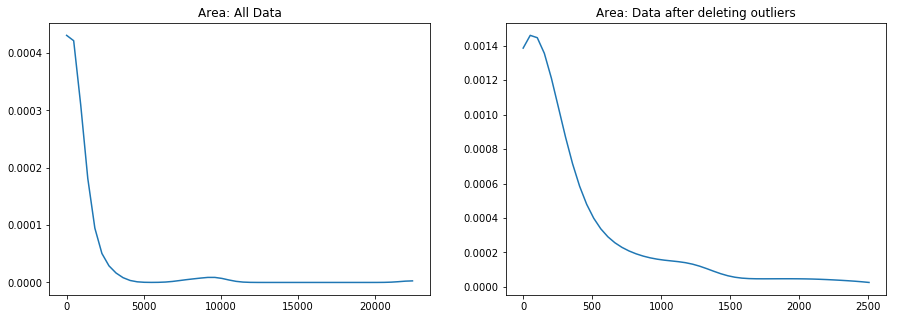

In [5]:
x=df[3]
x=x.dropna()

plt.rcParams['figure.figsize'] = (15,5)
f, (ax1, ax2) = plt.subplots(1, 2)
positions, smoothed = kde_values(x)
ax1.plot(positions, smoothed)
ax1.set_title('Area: All Data')
positions, smoothed = kde_values(x[x<2777])
ax2.plot(positions, smoothed)
ax2.set_title('Area: Data after deleting outliers')
plt.show()

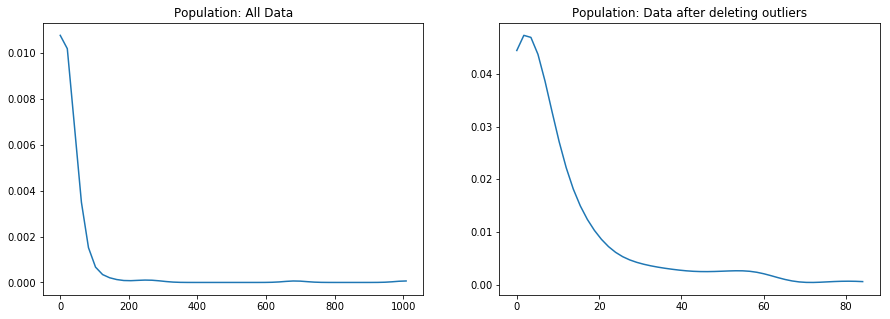

In [6]:
x=df[4]
x=x.dropna()

plt.rcParams['figure.figsize'] = (15,5)
f, (ax1, ax2) = plt.subplots(1, 2)
positions, smoothed = kde_values(x)
ax1.plot(positions, smoothed)
ax1.set_title('Population: All Data')
positions, smoothed = kde_values(x[x<85.68])
ax2.plot(positions, smoothed)
ax2.set_title('Population: Data after deleting outliers')
plt.show()

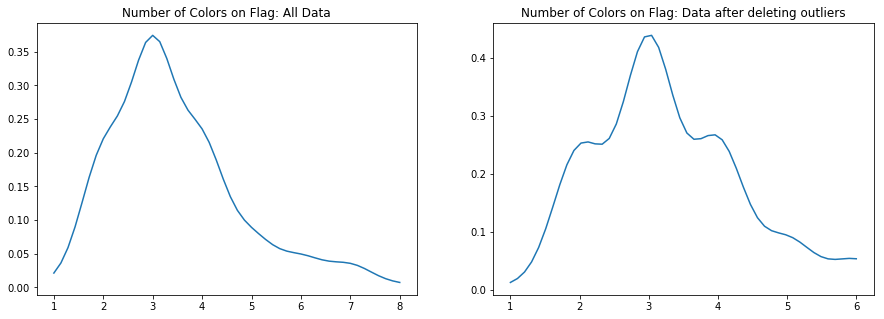

In [7]:
x=df[9]
x=x.dropna()

plt.rcParams['figure.figsize'] = (15,5)
f, (ax1, ax2) = plt.subplots(1, 2)
positions, smoothed = kde_values(x)
ax1.plot(positions, smoothed)
ax1.set_title('Number of Colors on Flag: All Data')
positions, smoothed = kde_values(x[x<6.28])
ax2.plot(positions, smoothed)
ax2.set_title('Number of Colors on Flag: Data after deleting outliers')
plt.show()

In [8]:
df[3]=df[3].map(lambda x: None if x>m[0] else x)
df[4]=df[4].map(lambda x: None if x>m[1] else x)
df[9]=df[9].map(lambda x: None if x>m[2] else x)

In [9]:
m1=df[3].quantile(0.96)
df[3]=df[3].map(lambda x: None if x>m1 else x)
m1

1840.6400000000003

In [10]:
m2=df[4].quantile(0.96)
df[4]=df[4].map(lambda x: None if x>m2 else x)
m2

51.99999999999997

In [11]:
m3=df[9].quantile(0.96)
df[9]=df[9].map(lambda x: None if x>m3 else x)
m3

6.0

In [12]:
x = df[3]
y = df[4]
z = df[9]

xx = [a for a in x if not np.isnan(a)]
yy = [a for a in y if not np.isnan(a)]
zz = [a for a in z if not np.isnan(a)]
print str(len(xx)) + ', ' + str(len(yy)) + ', ' + str(len(zz))

179, 178, 186


In [13]:
df = df.fillna(df.mean())
df.columns=['country','area (thousands of square of km)', 'population (millions)','religion','bars','stripes','numOfColors','red','green','blue','gold','white','black','orange','numOfCircles','numOfCrosses','numOfSaltires','numOfQuarters','numOfSunStars','crescent','triangle','icon','animate','text','inN.America','inS.America','inEurope','inAfrica','inAsia','inOceania','inNE','inSE','inSW','inNW','english','spanish','french','german','slavic','otherIndoEuropean','chinese','arabic','Japanese/Turkish/Finnish/Magyar','other',
            'mainColor_black','mainColor_blue','mainColor_brown','mainColor_gold','mainColor_green','mainColor_orange','mainColor_red','mainColor_white','topLeftColor_black','topLeftColor_blue','topLeftColor_gold','topLeftColor_green','topLeftColor_orange','topLeftColor_red','topLeftColor_white','bottomRightColor_black',
            'bottomRightColor_blue','bottomRightColor_brown',
            'bottomRightColor_gold','bottomRightColor_green',
            'bottomRightColor_orange','bottomRightColor_red',
            'bottomRightColor_white']
df.head()

,country,area (thousands of square of km),population (millions),religion,bars,stripes,numOfColors,red,green,blue,...,topLeftColor_red,topLeftColor_white,bottomRightColor_black,bottomRightColor_blue,bottomRightColor_brown,bottomRightColor_gold,bottomRightColor_green,bottomRightColor_orange,bottomRightColor_red,bottomRightColor_white
0,Afghanistan,648.000000,16.0,2,0,3,5.0,1,1,0,...,0,0,0,0,0,0,1,0,0,0
1,Albania,29.000000,3.0,6,0,0,3.0,1,0,0,...,1,0,0,0,0,0,0,0,1,0
2,Algeria,259.139665,20.0,2,2,0,3.0,1,1,0,...,0,0,0,0,0,0,0,0,0,1
3,American-Samoa,0.000000,0.0,1,0,0,5.0,1,0,1,...,0,0,0,0,0,0,0,0,1,0
4,Andorra,0.000000,0.0,0,3,0,3.0,1,0,1,...,0,0,0,0,0,0,0,0,1,0


In [14]:
data_df = df.drop(['country','religion'], axis=1)
target_df = df['religion']
data = data_df.as_matrix()
target = target_df.as_matrix()
from sklearn import preprocessing
# df[3] = preprocessing.StandardScaler().fit_transform(df[3])
# df[4] = preprocessing.StandardScaler().fit_transform(df[4])
# df[9] = preprocessing.StandardScaler().fit_transform(df[9])
data = preprocessing.StandardScaler().fit_transform(data)

data_df.head()

,area (thousands of square of km),population (millions),bars,stripes,numOfColors,red,green,blue,gold,white,...,topLeftColor_red,topLeftColor_white,bottomRightColor_black,bottomRightColor_blue,bottomRightColor_brown,bottomRightColor_gold,bottomRightColor_green,bottomRightColor_orange,bottomRightColor_red,bottomRightColor_white
0,648.000000,16.0,0,3,5.0,1,1,0,1,1,...,0,0,0,0,0,0,1,0,0,0
1,29.000000,3.0,0,0,3.0,1,0,0,1,0,...,1,0,0,0,0,0,0,0,1,0
2,259.139665,20.0,2,0,3.0,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,1
3,0.000000,0.0,0,0,5.0,1,0,1,1,1,...,0,0,0,0,0,0,0,0,1,0
4,0.000000,0.0,3,0,3.0,1,0,1,1,0,...,0,0,0,0,0,0,0,0,1,0


In [15]:
# create Decision Tree Classifier and determine which features are most important
from sklearn import tree
import numpy as np
clf = tree.DecisionTreeClassifier()
clf.fit(data,target)

y_pred = clf.predict(data)
classif_rate = np.mean(y_pred.ravel() == target.ravel()) * 100
print("classif_rate for %s : %f " % ('DecisionTreeClassifier', classif_rate))
print clf.feature_importances_

classif_rate for DecisionTreeClassifier : 100.000000 
[ 0.07397026  0.09657714  0.03223662  0.01762269  0.06961505  0.
  0.02094003  0.          0.          0.          0.          0.01542374
  0.          0.02507293  0.          0.00890903  0.00967099  0.
  0.00583329  0.          0.01547358  0.01146191  0.          0.
  0.00820569  0.09200685  0.07278817  0.          0.          0.01031572
  0.          0.          0.12734025  0.04854566  0.          0.          0.
  0.01141539  0.          0.09931701  0.          0.01968249  0.          0.
  0.          0.          0.01435995  0.          0.00859643  0.01674124
  0.          0.00644732  0.          0.01547358  0.          0.02729367
  0.00576866  0.          0.          0.          0.          0.00644732
  0.          0.00644732  0.        ]


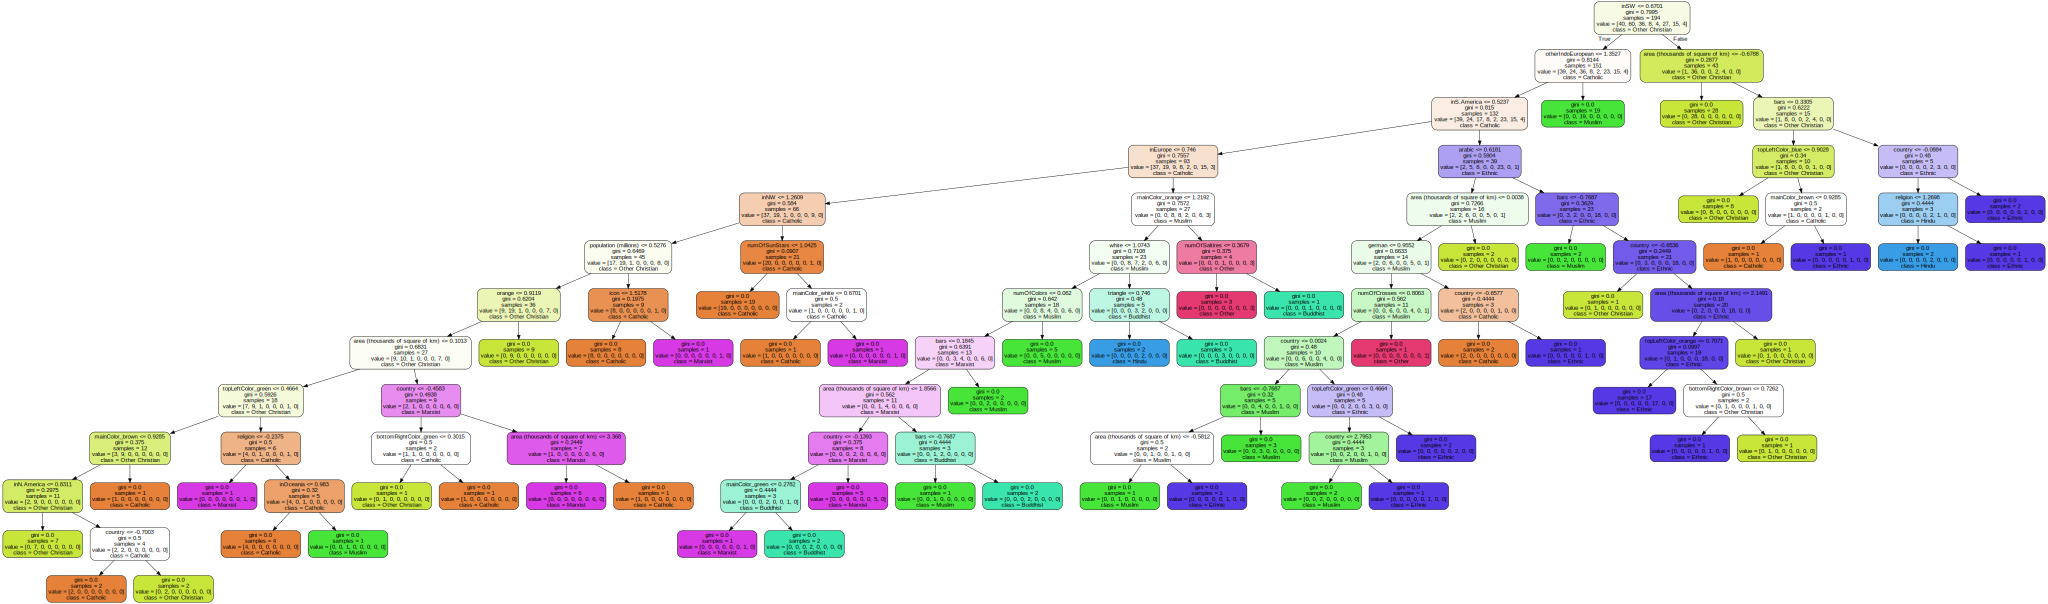

In [16]:
# visualize the decision tree
import graphviz
dot_data = tree.export_graphviz(clf, out_file=None,
#                                max_depth=5,
                               filled=True, rounded=True,
                               feature_names=df.columns,
                               class_names=['Catholic','Other Christian', 'Muslim', 'Buddhist', 'Hindu', 'Ethnic', 'Marxist', 'Other']) 
graph = graphviz.Source(dot_data)  
graph

In [17]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

models = [DecisionTreeClassifier(), RandomForestClassifier(), GradientBoostingClassifier(), SVC(), MLPClassifier()]
tuned_parameters = [{'max_depth': [None,10,20], 'criterion': ['gini','entropy']}, # parameters for decision tree
                   {'n_estimators':[10,20,30,40], 'max_depth':[None, 10, 20], 'criterion': ['gini','entropy']}, # parameters for random forest
                   {'n_estimators':[10,20,30,40], 'max_depth':[None, 10, 20]}, # parameters for gradient boost
                   {'decision_function_shape':['ovo'], 'degree':[1,2,3,4,5]}, # parameters for support vector machine
                   {'solver': ['lbfgs', 'sgd', 'adam'], 'max_iter': [200, 300, 400]} # parameters for neural network
                   ]
for model, tuned_parameter in zip(models, tuned_parameters):
    classify = GridSearchCV(model,tuned_parameter,cv=4,verbose=1)
    classify.fit(data,target)
    print classify.best_params_
    print classify.best_score_ 

Fitting 4 folds for each of 6 candidates, totalling 24 fits
{'criterion': 'entropy', 'max_depth': 10}
0.587628865979
Fitting 4 folds for each of 24 candidates, totalling 96 fits


[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  96 out of  96 | elapsed:    9.0s finished


{'n_estimators': 30, 'criterion': 'gini', 'max_depth': 10}
0.716494845361
Fitting 4 folds for each of 12 candidates, totalling 48 fits


[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed:   12.1s finished


{'n_estimators': 40, 'max_depth': None}
0.60824742268
Fitting 4 folds for each of 5 candidates, totalling 20 fits
{'decision_function_shape': 'ovo', 'degree': 1}
0.649484536082
Fitting 4 folds for each of 9 candidates, totalling 36 fits


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.2s finished
/Users/colepolychronis/anaconda/lib/python2.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:    5.3s finished


{'max_iter': 400, 'solver': 'sgd'}
0.649484536082


In [18]:
from sklearn.metrics import r2_score, accuracy_score

classify = RandomForestClassifier(n_estimators = 40, max_depth = 10, criterion='gini')
classify.fit(data,target)

y_pred = classify.predict(data)
classif_rate = np.mean(np.equal(y_pred.ravel(), target.ravel())) * 100
# classif_rate = np.mean(y_pred.ravel() == data.ravel()) * 100
print("classif_rate for %s : %f " % ('RandomForestClassifier', classif_rate))
print classify.feature_importances_

classif_rate for RandomForestClassifier : 99.484536 
[  7.12244956e-02   6.85357812e-02   2.25387814e-02   3.51086675e-02
   2.12252977e-02   9.21837328e-03   1.88955470e-02   1.27401523e-02
   1.97443654e-02   1.38652595e-02   1.05306716e-02   7.04404693e-03
   1.05210383e-02   2.95779077e-02   6.44234272e-03   9.23908049e-03
   2.16974989e-02   8.23460069e-03   7.84867119e-03   7.79508791e-03
   1.00316737e-02   2.09293154e-03   1.28879671e-02   2.10211986e-02
   1.80811895e-02   5.50662548e-02   4.40218986e-02   8.68964633e-03
   3.69435819e-02   1.37330508e-02   2.02705406e-03   1.07773537e-02
   4.54538507e-02   4.75726248e-02   1.00496097e-02   2.09148059e-03
   3.40730856e-03   1.05408454e-02   3.78035945e-03   5.36627068e-02
   2.60291002e-03   2.51182278e-02   2.50323523e-03   9.11283594e-03
   1.14981969e-03   4.35085063e-03   8.50951021e-03   9.01746788e-04
   7.74154961e-03   1.18153130e-02   7.69135539e-03   8.10705881e-03
   1.30193007e-03   8.41986774e-03   2.12661576e-0

In [19]:
from sklearn.model_selection import cross_val_score
dec = RandomForestClassifier(n_estimators = 40, max_depth = 20, criterion='gini')
scores = cross_val_score(dec, data, target, cv=4)
print("Model Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Model Accuracy: 0.71 (+/- 0.10)


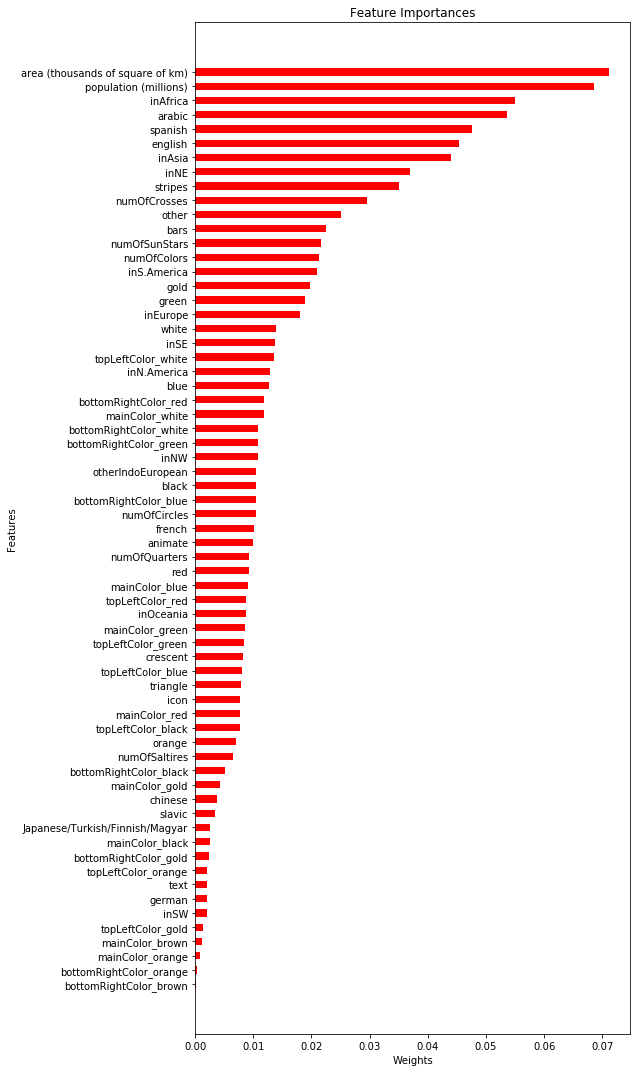

In [20]:
import matplotlib.pyplot as plt
features= data_df.columns.values
value = classify.feature_importances_
ind=sorted(range(len(value)),reverse=False,key=lambda k: value[k])
features=features[ind]
value=sorted(value,reverse=False)
ind=np.array(range(len(features)))
plt.rcParams['figure.figsize'] = (9,15)
plt.barh(bottom=ind,height=0.5,width=value,color='r')
plt.yticks(ind,features)
plt.xlabel('Weights')
plt.ylabel('Features')
plt.title('Feature Importances')
plt.tight_layout()
plt.show()

In [15]:
import pandas as pd
import numpy as np

df2 = pd.DataFrame(np.random.randint(100000000, 
                                    size = (14, 67)))
df2.columns = ['country','area (thousands of square of km)', 'population (millions)','religion','bars','stripes','numOfColors','red','green','blue','gold','white','black','orange','numOfCircles','numOfCrosses','numOfSaltires','numOfQuarters','numOfSunStars','crescent','triangle','icon','animate','text','inN.America','inS.America','inEurope','inAfrica','inAsia','inOceania','inNE','inSE','inSW','inNW','english','spanish','french','german','slavic','otherIndoEuropean','chinese','arabic','Japanese/Turkish/Finnish/Magyar','other',
                                                'mainColor_black','mainColor_blue','mainColor_brown','mainColor_gold','mainColor_green','mainColor_orange','mainColor_red','mainColor_white','topLeftColor_black','topLeftColor_blue','topLeftColor_gold','topLeftColor_green','topLeftColor_orange','topLeftColor_red','topLeftColor_white','bottomRightColor_black',
                                                'bottomRightColor_blue','bottomRightColor_brown',
                                                'bottomRightColor_gold','bottomRightColor_green',
                                                'bottomRightColor_orange','bottomRightColor_red',
                                                'bottomRightColor_white']
df2.head()

TypeError: __init__() got an unexpected keyword argument 'size'